# Assignment 2 - Volti

## Emanuele Muzio - 0766230

Per questo secondo assignment, viene richiesto di implementare un sistema di riconoscimento dei volti "closel-world" basandoci sugli autovolti.

Si richiede di catturare in un video il movimento delle persone selezionate per l'assignment e, per ogni frame, mostrare le etichette delle persone risconosciute.

Dettagli aggiuntivi:

- Resize delle immagini a 64x64
- Per l'estrazione del descrittore basato su autovolti (Turk Pentland), eseguire una buona stima dello spazio dei volti. Usare il dataset "Labeled faces in the wild" per stimare un volto medio e gli autovolti significativi (si consiglia di usare il dataset "All images aligned with funneling" da http://vis-www.cs.umass.edu/lfw/ con immagini già allineate, non viene richiesto di usare tutte le immagini del dataset ma almeno 2000, è consigliabile salvare i risultati per conservare i risultati dello spazio dei volti usando il pickle package).
- Creare una galleria delle identità da riconoscere. Possiamo immaginare la galleria come un insieme di immagini facciali etichettate. Sarebbe consigliabile catturare diverse immagini per ogni volto, con ogni volta diversa espressione e orientazione della testa. La galleria deve contenere almeno 4 persone, ma possiamo includere a nostra discrezione più identità. La galleria deve essere costruita una volta sola. Possiamo salvare la galleria su disco usando il pickle package
- Per il rilevamento facciale per costruira la galleria e implementare un riconoscimento dell'identità quasi in real-time, useremo l'implementazione di OpenCV del rilevamento facciale Viola Jones. Scaricare dalla repo pubblica di opencv il file haarcascade_frontalface_alt.xml
- Usare un classificatore per associare il descrittore del volto di un viso a un'identità nota. Possiamo usare un classificatore K-NN 
- Includere un test di validazione diverso dai dati usati per l'addestramento e di test (video di 20-30 frame delle persone che camminano in uno spazio)

## Risultati attesi

E' obbligatorio includere un notebook Jupyter con la risoluzione.

Inoltre, è obbligatorio presentare un'analisi dei risultati ottenuti:
- Risultati ottenuti variando il numero di autovolti: questo dovrebbe essere selezionato per coprire tra il 95% e il 99.9% della varianza totale (la varianza coperta viene ottenuta analizzando i valori singolari normalizzati!)
- Risultati con valori diversi di K (1, 3, 5)

Scegli il valore di K e la varianza coperta sul set di validazione per scegliere il modello migliore. Riportare gli errori fatti dal sistema sul test di validazione o di addestramento. Non è necessario presentare risultati quantitativi sull'insieme di test.

## Opzionale

- Allineare i volti al volto medio usando gli occhi, che possono essere trovati da un altro classificatore a cascata, che non è perfetto. L'allineamento richiede una roto-traslazione 2D. L'allineamento dei volti dovrebbe migliorare il sistema di riconoscimento facciale
- Provare a sfruttare il multi-threading per acquisizione ed elaborazione dei frame dell'immagine (per processare direttamente i frame della camera)

# 1. Costruzione classificatore e mean face

Il primo passo consiste nell'inizializzatore del classificatore. 

Nel nostro caso, per mantenere la semplicità è stato scelto l'utilizzo di un solo classificatore per i volti (l'xml per l'inizializzazione è disponibile sulla repo github di OpenCV).

I volti per la creazione della Mean Face sono stati scaricati da http://vis-www.cs.umass.edu/lfw/. 

I volti, già allineati, sono stati trasformati nel seguente modo per essere più fedeli a un classico approccio della CV per l'elaborazione dei volti, che prevedono appunto dei passaggi di pre-elaborazione:

- Resi in gray scale
- Resize per adattarli alla dimensione desiderata 64x64
- Crop del solo viso
- Normalizzazione min-max dell'immagine

In [14]:
import utils
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import os

lfw_dict = None

_CLASSIFIER_XML = ["haarcascade_frontalface_alt.xml"]
_LFW_IMGS = 'lfw_imgs'
_LFW_DIR = 'lfw_funneled'

if os.path.exists(_LFW_IMGS):
    print("[INFO] LFW pickle")
    lfw_dict = utils.load(_LFW_IMGS)
else:
    print("[INFO] LFW new")
    classifier = utils.buildClassifier(_CLASSIFIER_XML)
    if classifier is not None:
        h_resize, w_resize = 64, 64
        lfw_dict = utils.getImgsDict(_LFW_DIR, h_resize, w_resize, classifier)
        utils.save(_LFW_IMGS, lfw_dict)
    else:
        raise Exception("[ERROR] Unable to init classifier")

[INFO] LFW pickle


A partire dal dataset estratto calcoliamo la mean face, che sarà di fondamentale importanza per i calcoli successivi

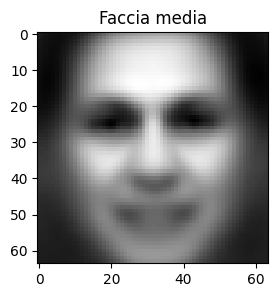

In [15]:
lfw_imgs = []
    
for _, v in lfw_dict.items():
    lfw_imgs.extend(v)
    
np.random.shuffle(lfw_imgs)
        
mean_face = utils.getMeanFace(lfw_imgs)

fig, axes = plt.subplots(1,1,sharex=True,sharey=True,figsize=(3,3))
axes.imshow(mean_face, cmap="gray")
axes.set_title("Faccia media")
plt.show()

# 2. Creazione galleria e ricerca eigenfaces rilevanti

Fatto questo, procediamo a caricare usando lo stesso procedimento già visto le immagini della nostra galleria di volti noti.

In [16]:
_GALLERY_IMGS = 'gallery_imgs'
_GALLERY_DIR = 'gallery'

gallery_dict = None
gallery_imgs = []
known_ids = ["Davide_Sgroi", "Francesco_Conti","Gabriele_Musso", "Stefano_Corrao"]
identity_map = []

if os.path.exists(_GALLERY_IMGS):
    print("[INFO] Gallery pickle")
    gallery_dict = utils.load(_GALLERY_IMGS)
else:
    print("[INFO] Creating gallery from the imgs")
    classifier = utils.buildClassifier(_CLASSIFIER_XML)
    if classifier is not None:
        h_resize, w_resize = 64, 64
        gallery_dict = utils.getImgsDict(_GALLERY_DIR, h_resize, w_resize, classifier)
        utils.save(_GALLERY_IMGS, gallery_dict)
    else:
        raise Exception("[ERROR] Unable to init classifier")

for identity, g_faces in gallery_dict.items():
    for g_face in g_faces:
        gallery_imgs.append(g_face.flat)
        identity_map.append(identity)
        
for i in range(len(identity_map)):
    identity_map[i] = known_ids.index(identity_map[i])
        
gallery_imgs = np.vstack(gallery_imgs)

[INFO] Gallery pickle


Dovendo concentrarci sugli autovolti più significativi per motivi di ottimizzazione, andremo a considerare solo quelle che coprono una varianza tale da suscitare interesse ed essere considerati dei buoni descrittori (nel nostro caso, quelle che coprono almeno il 95% della varianza cumulata e il 99.99%).

In questa implementazione saltiamo un passaggio intermedio avvalendoci della decomposizione PCA di scikit learn. Il passaggio in questione prevederebbe la costruzione di una matrice di covarianza di dimensioni (nel nostro caso) 4096x4096, da cui estrarre tramite SVD i valori singolari e normalizzarli per ottenere quindi le facce rilevanti. Lo stesso risultato però viene ottenuto tramite analisi delle componenti principali delle nostre immagini di addestramento vettorizzate.

In [17]:
_FACE_SPACE = 'face_space'
index95  = None
eigenfaces95 = None 
index99 = None
eigenfaces99 = None

flat_lfw = []
m = np.reshape(mean_face, (4096, 1))

for img in lfw_imgs:
    flat_lfw.append(img.flatten())
    
flat_lfw = np.vstack(flat_lfw)

if os.path.exists(_FACE_SPACE):
    face_space = utils.load(_FACE_SPACE)
    index95 = face_space["index95"]
    index99 = face_space["index99"]
    eigenfaces95 = face_space["eigenfaces95"]
    eigenfaces99 = face_space["eigenfaces99"] 
else:
    pca = PCA()
    pca.fit(flat_lfw)
    expl_var_ratio = pca.explained_variance_ratio_.cumsum()

    index95 = list(map(lambda i: i > 0.95, expl_var_ratio)).index(True)
    index99 = list(map(lambda i: i > 0.99, expl_var_ratio)).index(True)
        
    eigenfaces95 = pca.components_[:index95]
    eigenfaces99 = pca.components_[:index99]
    
    face_space = {
        "index95" : index95,
        "index99" : index99,
        "eigenfaces95" : eigenfaces95,
        "eigenfaces99" : eigenfaces99
    }
    
    utils.save(_FACE_SPACE, face_space)

# 3. Proiezione volti noti e classificazione di prova

Possiamo adesso procedere a proiettare i volti della nostra galleria nel face space. Una parte di questi volti verrà usata per l'addestramento supervisionato del classificatore, il resto per testarne la bontà.

Usiamo un classificatore K-NN testando con 1, 3 e 5 vicini.

In [18]:
proj95  = []
proj99 = []
m = mean_face.flat

for x in gallery_imgs:
    proj95.append(eigenfaces95 @ (x - m))
    proj99.append(eigenfaces99 @ (x - m))

In [19]:
i_95 = list(range(len(proj95)))
i_99 = list(range(len(proj99)))

# Dovendo mantenere l'informazione sulle label quando facciamo lo shuffle per la creazione degli
# insiemi di train e test, facciamo prima train test split sugli indici e andiamo a rimappare

i_train_95, i_val_95, train_labels_95, val_labels_95 = train_test_split(i_95, identity_map, test_size=0.2)
i_train_99, i_val_99, train_labels_99, val_labels_99 = train_test_split(i_99, identity_map, test_size=0.2)

train95 = [proj95[i] for i in i_train_95]
val95 = [proj95[i] for i in i_val_95]

train99 = [proj99[i] for i in i_train_99]
val99 = [proj99[i] for i in i_val_99]

In [20]:
knn_1_95 = KNeighborsClassifier(n_neighbors=1)
knn_1_95.fit(train95, train_labels_95)
knn_1_95_pred = knn_1_95.predict(val95)

knn_1_99 = KNeighborsClassifier(n_neighbors=1)
knn_1_99.fit(train99, train_labels_99)
knn_1_99_pred = knn_1_99.predict(val99)

knn_3_95 = KNeighborsClassifier(n_neighbors=3)
knn_3_95.fit(train95, train_labels_95)
knn_3_95_pred = knn_3_95.predict(val95)

knn_3_99 = KNeighborsClassifier(n_neighbors=3)
knn_3_99.fit(train99, train_labels_99)
knn_3_99_pred = knn_3_99.predict(val99)

knn_5_95 = KNeighborsClassifier(n_neighbors=5)
knn_5_95.fit(train95, train_labels_95)
knn_5_95_pred = knn_5_95.predict(val95)

knn_5_99 = KNeighborsClassifier(n_neighbors=5)
knn_5_99.fit(train99, train_labels_99)
knn_5_99_pred = knn_5_99.predict(val99)

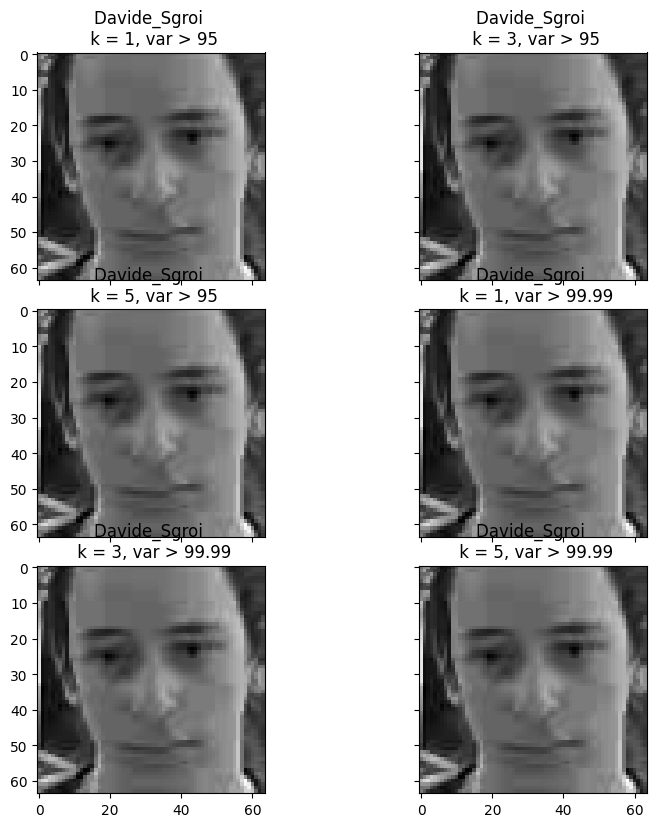

In [21]:
fig, axes = plt.subplots(3, 2,sharex=True,sharey=True,figsize=(8,8))

dim = 64

fig.tight_layout()

axes[0][0].imshow(gallery_imgs[knn_1_95_pred[0]].reshape(dim,dim), cmap="gray")
axes[0][0].set_title(f"{known_ids[knn_1_95_pred[0]]} \n k = 1, var > 95")

axes[0][1].imshow(gallery_imgs[knn_3_95_pred[0]].reshape(dim,dim), cmap="gray")
axes[0][1].set_title(f"{known_ids[knn_3_95_pred[0]]} \n k = 3, var > 95")

axes[1][0].imshow(gallery_imgs[knn_5_95_pred[0]].reshape(dim,dim), cmap="gray")
axes[1][0].set_title(f"{known_ids[knn_5_95_pred[0]]} \n k = 5, var > 95")

axes[1][1].imshow(gallery_imgs[knn_1_99_pred[0]].reshape(dim,dim), cmap="gray")
axes[1][1].set_title(f"{known_ids[knn_1_99_pred[0]]} \n k = 1, var > 99.99")

axes[2][0].imshow(gallery_imgs[knn_3_99_pred[0]].reshape(dim,dim), cmap="gray")
axes[2][0].set_title(f"{known_ids[knn_3_99_pred[0]]} \n k = 3, var > 99.99")

axes[2][1].imshow(gallery_imgs[knn_5_99_pred[0]].reshape(dim,dim), cmap="gray")
axes[2][1].set_title(f"{known_ids[knn_5_99_pred[0]]} \n k = 5, var > 99.99")

plt.show()

Misure di accuracy per le foto

In [22]:
from sklearn.metrics import accuracy_score

accuracy_list = [
    accuracy_score(val_labels_95, knn_1_95_pred),
    accuracy_score(val_labels_95, knn_3_95_pred),
    accuracy_score(val_labels_95, knn_5_95_pred),
    accuracy_score(val_labels_99, knn_1_99_pred),
    accuracy_score(val_labels_99, knn_3_99_pred),
    accuracy_score(val_labels_99, knn_5_99_pred)
]

print('Accuracy Table per le foto')
print("\nN = 1, var = 95\t", str(round(accuracy_list[0], 2)))
print("\nN = 3, var = 95\t", str(round(accuracy_list[1], 2)))
print("\nN = 5, var = 95\t", str(round(accuracy_list[2], 2)))
print("\nN = 1, var = 99\t", str(round(accuracy_list[3], 2)))
print("\nN = 3, var = 99\t", str(round(accuracy_list[4], 2)))
print("\nN = 5, var = 99\t", str(round(accuracy_list[5], 2)))

Accuracy Table per le foto

N = 1, var = 95	 0.98

N = 3, var = 95	 0.98

N = 5, var = 95	 0.96

N = 1, var = 99	 0.99

N = 3, var = 99	 0.97

N = 5, var = 99	 0.97


# 4. Annotazione automatica e manuale

Procediamo ora a scegliere il modello migliore usando un vide di una ventina di frame come validation set, testando poi il modello scelto su un video di test.

In [23]:
# Ho invertito nomi delle variabili di test e validazione

validation_set = []
classifier = utils.buildClassifier(_CLASSIFIER_XML)

frame_cap_model_sel = 20
model_sel_fps = 3

for i in range(frame_cap_model_sel):
    validation_set.append(["Francesco_Conti", "Stefano_Corrao", "Davide_Sgroi","Gabriele_Musso"])

detected_faces_1_95 = utils.detectFaces('lab_raw.mp4', "knn_1_95_" + 'lab_auto.mp4', classifier, knn_1_95, eigenfaces95, m, known_ids, frame_cap_model_sel, model_sel_fps)

detected_faces_3_95 = utils.detectFaces('lab_raw.mp4', "knn_3_95_" + 'lab_auto.mp4', classifier, knn_3_95, eigenfaces95, m, known_ids, frame_cap_model_sel, model_sel_fps)

detected_faces_5_95 = utils.detectFaces('lab_raw.mp4', "knn_5_95_" + 'lab_auto.mp4', classifier, knn_5_95, eigenfaces95, m, known_ids, frame_cap_model_sel, model_sel_fps)

detected_faces_1_99 = utils.detectFaces('lab_raw.mp4', "knn_1_99_" + 'lab_auto.mp4', classifier, knn_1_99, eigenfaces99, m, known_ids, frame_cap_model_sel, model_sel_fps)

detected_faces_3_99 = utils.detectFaces('lab_raw.mp4', "knn_3_99_" + 'lab_auto.mp4', classifier, knn_3_99, eigenfaces99, m, known_ids, frame_cap_model_sel, model_sel_fps)

detected_faces_5_99 = utils.detectFaces('lab_raw.mp4', "knn_5_99_" + 'lab_auto.mp4', classifier, knn_5_99, eigenfaces99, m, known_ids, frame_cap_model_sel, model_sel_fps)

In [24]:
knn_list = [knn_1_95, knn_3_95, knn_5_95, knn_1_99, knn_3_99, knn_5_99]
detected_faces = [
    detected_faces_1_95,
    detected_faces_3_95,
    detected_faces_5_95,
    detected_faces_1_99,
    detected_faces_3_99,
    detected_faces_5_99
]
score_list = []

for df_ in detected_faces:
    acc_sum = 0
    for i in range(len(df_)):
        acc_sum += accuracy_score(validation_set[i], df_[i])
    acc_sum /= len(df_)
    score_list.append(acc_sum)
    
max_score = max(score_list)
index = score_list.index(max_score)
best_knn = knn_list[index]
best_eigenfaces = None

if index < 3:
    N = best_knn.get_params()['n_neighbors']
    best_eigenfaces = eigenfaces95
    print(f'Model selection result: KNN with N = {N} and cum. var. > 95%, accuracy: {max_score}')
else:
    N = best_knn.get_params()['n_neighbors']
    best_eigenfaces = eigenfaces99
    print(f'Model selection result: KNN with N = {N} and cum. var. > 99.99%, accuracy: {max_score}')

Model selection result: KNN with N = 3 and cum. var. > 99.99%, accuracy: 0.2875


In [25]:
test_video = 'Video finale senza riconoscimento.mp4'
frame_cap_test = 2000
fps_test = 24

detected_faces_final = utils.detectFaces(test_video, 'final_auto.mp4', classifier, best_knn, best_eigenfaces, m, known_ids, frame_cap_test, fps_test)